In [1]:
%matplotlib inline
import requests
import urllib2
import bs4
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import psycopg2
import string

In [2]:
jobs = pd.read_csv('job_searches.csv')

In [3]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1326 entries, 0 to 1325
Data columns (total 16 columns):
company                 1326 non-null object
culture                 1326 non-null object
job_addr                1326 non-null object
job_description         1326 non-null object
job_posted              1326 non-null object
job_security_advance    1326 non-null object
job_title               1326 non-null object
link                    1326 non-null object
management              1326 non-null object
reviews_score           1326 non-null float64
reviews_total           1326 non-null object
salary                  1326 non-null object
salary_benefits         1326 non-null object
salary_bins             1326 non-null object
work_life_bal           1326 non-null object
salary_bins_int         1326 non-null int64
dtypes: float64(1), int64(1), object(14)
memory usage: 165.8+ KB


In [4]:
jobs.drop(labels=['salary_bins', 'salary', 'job_posted'], axis=1, inplace=True)
jobs.head()

,company,culture,job_addr,job_description,job_security_advance,job_title,link,management,reviews_score,reviews_total,salary_benefits,work_life_bal,salary_bins_int
0,Virgin Australia,3.8,Sydney NSW,\nThe role of a Data Scientist. Ability to pre...,3.6,Data Scientist,http://au.indeed.com/rc/clk?jk=e878a8a83d2ae2a...,3.6,4.0,19,3.6,3.8,80000
1,AMP Limited,3.8,Sydney NSW,\nData analysis projects. Developing algorithm...,3.5,Data Scientist - Insurance Data Analytics,http://au.indeed.com/rc/clk?jk=4d25733cec0da29...,3.6,4.1,115,3.8,4.0,80000
2,General Assembly,4.1,Sydney NSW,\nData visualization techniques; Data Science ...,3.7,Part Time Data Science Instructor,http://au.indeed.com/rc/clk?jk=49481b391a9be1c...,4.0,4.3,73,4.0,4.0,80000
3,CSIRO,3.9,Sydney NSW,"\nBayesian nonparametrics, Nonhomogenous stoch...",3.1,Postdoctoral Fellow - Data Analytics,http://au.indeed.com/rc/clk?jk=22027439f55f287...,3.7,4.3,22,3.9,4.3,80000
4,Atlassian,3.6,Sydney NSW,\nIf you're a great developer with an inclinat...,3.4,Data / Product Analyst,http://au.indeed.com/rc/clk?jk=b61dc9bc2976ccf...,3.2,4.2,6,4.8,4.2,80000


In [5]:
jobs.reviews_score.value_counts()

4.0    262
3.3    112
3.8     88
4.2     82
4.1     80
4.3     74
4.5     72
3.5     71
3.9     68
3.7     63
5.0     56
3.0     40
4.7     36
2.0     35
3.6     30
2.5     30
4.4     30
4.8     29
3.2     26
4.6     14
3.4     13
2.6      5
2.9      4
1.0      2
2.4      2
1.5      1
2.7      1
Name: reviews_score, dtype: int64

In [6]:
jobs.job_addr.unique()

array(['Sydney NSW', 'Sydney Central Business District NSW',
       'Westmead NSW', 'Darlinghurst NSW', 'Lucas Heights NSW',
       'Macquarie University NSW', 'Matraville NSW', 'Bondi Junction NSW',
       'Melbourne VIC', 'Melbourne City Centre VIC', 'Clayton VIC',
       'Parkville VIC', 'Brunswick East VIC', 'San Francisco, CA',
       'San Francisco, CA 94103 (South Of Market area)', 'Berkeley, CA',
       'South San Francisco, CA', 'Redwood Shores, CA',
       'San Francisco, CA 94143 (Inner Sunset area)',
       'San Francisco, CA 94105 (Financial District area)',
       'San Francisco, CA 94158 (South Of Market area)',
       'Redwood City, CA 94063', 'San Francisco Bay Area, CA',
       'Redwood City, CA', 'San Ramon, CA', 'Oakland, CA',
       'San Carlos, CA', 'Fremont, CA 94555 (Northgate area)',
       'Foster City, CA', 'San Francisco, CA 94102 (Downtown area)',
       'San Leandro, CA', 'Berkeley, CA 94720',
       'South San Francisco, CA 94080', 'Menlo Park, CA 94025',

In [7]:
states=[]

for i in jobs.job_addr:
    if 'CA' in i:
        states.append('CA')
    elif 'NSW' in i:
        states.append('NSW')
    elif 'VIC' in i:
        states.append('VIC')
    else:
        states.append('i')
        
jobs['state'] = states

jobs.state.unique()

array(['NSW', 'VIC', 'CA'], dtype=object)

### Convert to USD

In [8]:
jobs['adj_salary_bin'] = jobs.salary_bins_int.where(jobs.state == 'CA', jobs.salary_bins_int*0.77)
jobs

,company,culture,job_addr,job_description,job_security_advance,job_title,link,management,reviews_score,reviews_total,salary_benefits,work_life_bal,salary_bins_int,state,adj_salary_bin
0,Virgin Australia,3.8,Sydney NSW,\nThe role of a Data Scientist. Ability to pre...,3.6,Data Scientist,http://au.indeed.com/rc/clk?jk=e878a8a83d2ae2a...,3.6,4.0,19,3.6,3.8,80000,NSW,61600.0
1,AMP Limited,3.8,Sydney NSW,\nData analysis projects. Developing algorithm...,3.5,Data Scientist - Insurance Data Analytics,http://au.indeed.com/rc/clk?jk=4d25733cec0da29...,3.6,4.1,115,3.8,4.0,80000,NSW,61600.0
2,General Assembly,4.1,Sydney NSW,\nData visualization techniques; Data Science ...,3.7,Part Time Data Science Instructor,http://au.indeed.com/rc/clk?jk=49481b391a9be1c...,4.0,4.3,73,4.0,4.0,80000,NSW,61600.0
3,CSIRO,3.9,Sydney NSW,"\nBayesian nonparametrics, Nonhomogenous stoch...",3.1,Postdoctoral Fellow - Data Analytics,http://au.indeed.com/rc/clk?jk=22027439f55f287...,3.7,4.3,22,3.9,4.3,80000,NSW,61600.0
4,Atlassian,3.6,Sydney NSW,\nIf you're a great developer with an inclinat...,3.4,Data / Product Analyst,http://au.indeed.com/rc/clk?jk=b61dc9bc2976ccf...,3.2,4.2,6,4.8,4.2,80000,NSW,61600.0
5,CSIRO,3.9,Sydney NSW,\nKoribalski and her team on the ASKAP HI All ...,3.1,CSIRO Postdoctoral Fellow: ASKAP Big Data Inno...,http://au.indeed.com/rc/clk?jk=6bee32a45106f00...,3.7,4.3,22,3.9,4.3,80000,NSW,61600.0
6,NSW Government,4.7,Sydney NSW,\nScientist (Estuaries & Catchments). This pos...,4.3,Scientist (Estuaries & Catchments),http://au.indeed.com/rc/clk?jk=8b8d708bc78c25f...,4.3,4.7,7,4.3,4.3,80000,NSW,61600.0
7,CSIRO,3.9,Sydney NSW,"\nIn this research scientist position, you wil...",3.1,Research Scientist - Cyber Security,http://au.indeed.com/rc/clk?jk=0fc97c3dc96603e...,3.7,4.3,22,3.9,4.3,80000,NSW,61600.0
8,Morgan McKinley,3.7,Sydney NSW,"\nRole Data Scientist. My client, a leading me...",2.3,Data Scientist,http://au.indeed.com/rc/clk?jk=06a2f9a9ba16801...,3.3,4.0,4,3.0,3.7,80000,NSW,61600.0
9,General Assembly,4.1,Sydney NSW,\nOur Data Science Immersive course is a brand...,3.7,Data Science Immersive Instructor,http://au.indeed.com/rc/clk?jk=23859263aec0d64...,4.0,4.3,73,4.0,4.0,80000,NSW,61600.0


### Check distribution of salary and review scores

There are two clusters. One below 80,000 and one above 80,000. 

In [9]:
import seaborn as sb

In [10]:
jobs.adj_salary_bin.unique()

array([  61600.,   77000.,   92400.,  107800.,  123200.,   65000.,
         85000.,  100000.,  115000.,  130000.])

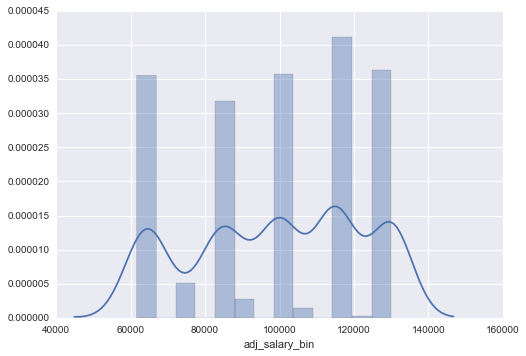

In [11]:
sb.distplot(jobs.adj_salary_bin)

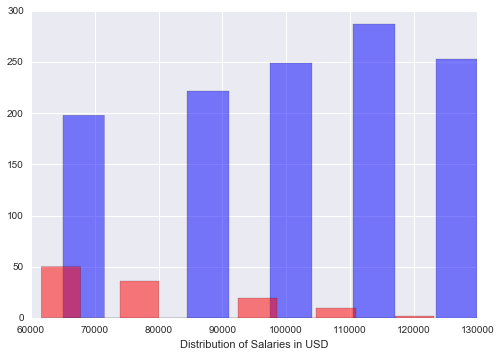

In [12]:
cali = jobs[jobs.state == 'CA']
aus = jobs[jobs.state != 'CA']

plt.hist(cali.adj_salary_bin, color='b', alpha=0.5)
plt.hist(aus.adj_salary_bin, color='r', alpha=0.5)
plt.xlabel('Distribution of Salaries in USD')

plt.show()

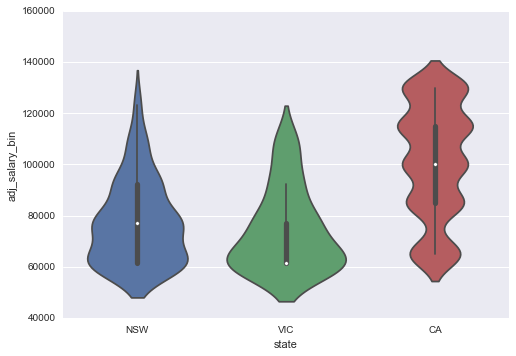

In [13]:
import seaborn as sb
sb.violinplot(x=jobs.state, y=jobs.adj_salary_bin, data=jobs)
plt.show()

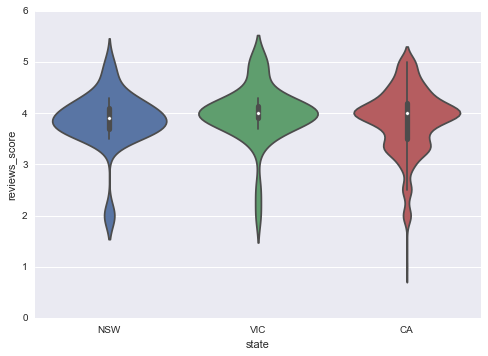

In [14]:
sb.violinplot(x=jobs.state, y=jobs.reviews_score, data=jobs)
plt.show()

### Create categorical columns

In [15]:
dictionary = {'CA':1, 'NSW':2, 'VIC':3}
jobs['state_number'] = jobs.state.map(dictionary)
jobs.state_number.unique()

dictionary = {'CA':1, 'NSW':0, 'VIC':0}
jobs['cali'] = jobs.state.map(dictionary)

jobs['over80000'] = np.where(jobs.adj_salary_bin > 80000, 1, 0)
jobs['review_over3'] = np.where(jobs.reviews_score > 3, 1, 0)

### Vectorize Data Science Job Titles

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LogisticRegression

tfidf = TfidfVectorizer()
key_words = tfidf.fit_transform(jobs.job_title).toarray()

print jobs.shape
print key_words.shape

X = key_words
y = jobs.adj_salary_bin

#elastic = ElasticNetCV()
#elastic.fit(X,y)


lr = LogisticRegression(class_weight='balanced')
lr.fit(X,y)




prob = lr.predict_proba(X)

print 'Salary & Coefs:'
print 'Ask if you would like to see'
print
#for i in zip(aus_jobs.adj_salary_bin.unique(), lr.coef_):
#    print i
#print

#Score and test against dummy
scoring = cross_val_score(lr,X,y,cv=5,scoring='accuracy')
print 'CV Score:'
print scoring.mean()
print

dum_score = cross_val_score(DummyClassifier(strategy='most_frequent'),X,y,cv=5,scoring='accuracy')
print 'Dummy Score:'
print dum_score.mean()
print

#Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

lr.fit(x_train,y_train)
y_pred = lr.predict(x_test)

cm = confusion_matrix(y_test,y_pred)
cr = classification_report(y_test, y_pred, digits=4)

print 'Confusion Matrix'
print cm
print

print 'Classification Report:'
print cr
print 

#word_impact = pd.DataFrame()
#word_impact['word'] = tfidf.get_feature_names()
#word_impact['elasticnet_coef'] = elastic.coef_
#sorted_words = word_impact.sort(columns='elasticnet_coef', ascending=False)
#print sorted_words.head(15)
#print sorted_words.tail(15)

(1326, 19)
(1326, 804)
Salary & Coefs:
Ask if you would like to see

CV Score:
0.285588200345

Dummy Score:
0.216449295118

Confusion Matrix
[[ 3  2  0  1  0  0  0  1  1  1]
 [ 5 33  3 12  2  4  1  4  1  4]
 [ 4  0  3  1  0  0  1  3  0  0]
 [ 3 29  8 20  2  4  4  6  0  6]
 [ 0  0  1  1  1  1  1  0  0  1]
 [ 1 12  9 14  2  8  2 17  2 12]
 [ 0  0  0  0  1  1  1  0  0  0]
 [ 3  6 11 12  1  8  0 23  3 31]
 [ 0  0  1  0  0  0  0  0  0  0]
 [ 4  3  4  2  0  2  0 19  3 42]]

Classification Report:
             precision    recall  f1-score   support

    61600.0     0.1304    0.3333    0.1875         9
    65000.0     0.3882    0.4783    0.4286        69
    77000.0     0.0750    0.2500    0.1154        12
    85000.0     0.3175    0.2439    0.2759        82
    92400.0     0.1111    0.1667    0.1333         6
   100000.0     0.2857    0.1013    0.1495        79
   107800.0     0.1000    0.3333    0.1538         3
   115000.0     0.3151    0.2347    0.2690        98
   123200.0     0.0000    

In [18]:
top_words = ['engineer','software','senior','director','product','lead','manager',
 'platform','learning','machine','analytics','architect']    
top_words = pd.DataFrame(columns=top_words)
top_words['link'] = jobs.link
jobsww = jobs.merge(top_words)

### Create Australia only table

### Imports needed for modelling

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### Modelling - ***Australia Only***

In [19]:
aus_jobs = jobs[jobs.state != 'CA']

In [20]:
dictionary = {'NSW':1, 'VIC':0}
aus_jobs['NSW'] = aus_jobs.state.map(dictionary)

/Users/allenbyron/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [22]:
#Variables
X = aus_jobs[['NSW']] #, 'review_over3', 'NSW']]
y = aus_jobs.adj_salary_bin 

In [39]:
#Initial exploratory regression
lr = LogisticRegression(class_weight='balanced')
lr.fit(X,y)

prob = lr.predict_proba(X)

print 'Salary & Coefs:'
for i in zip(aus_jobs.adj_salary_bin.unique(), lr.coef_):
    print i
print

#Score and test against dummy
scoring = cross_val_score(lr,X,y,cv=5,scoring='accuracy')
print 'CV Score:'
print scoring.mean()
print

dum_score = cross_val_score(DummyClassifier(strategy='most_frequent'),X,y,cv=5,scoring='accuracy')
print 'Dummy Score:'
print dum_score.mean()
print

#Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

lr.fit(x_train,y_train)
y_pred = lr.predict(x_test)

cm = confusion_matrix(y_test,y_pred)
cr = classification_report(y_test, y_pred, digits=4)

print 'Confusion Matrix'
print cm
print

print 'Classification Report:'
print cr
print 

Salary & Coefs:
(61600.0, array([-0.50353932]))
(77000.0, array([ 0.12136412]))
(92400.0, array([ 0.1167317]))
(107800.0, array([-0.39070812]))
(123200.0, array([ 1.09712276]))

CV Score:
0.361068511199

Dummy Score:
0.428155467721

Confusion Matrix
[[ 5 11  0  0  0]
 [ 2  9  0  0  0]
 [ 3  5  0  0  0]
 [ 1  2  0  0  0]
 [ 0  1  0  0  0]]

Classification Report:
             precision    recall  f1-score   support

    61600.0     0.4545    0.3125    0.3704        16
    77000.0     0.3214    0.8182    0.4615        11
    92400.0     0.0000    0.0000    0.0000         8
   107800.0     0.0000    0.0000    0.0000         3
   123200.0     0.0000    0.0000    0.0000         1

avg / total     0.2771    0.3590    0.2821        39




In [54]:
#Variables
X = aus_jobs[['reviews_score']]
y = aus_jobs.adj_salary_bin 

In [55]:
#Initial exploratory regression
lr = LogisticRegression(class_weight='balanced')
lr.fit(X,y)

prob = lr.predict_proba(X)

print 'Salary & Coefs:'
for i in zip(aus_jobs.adj_salary_bin.unique(), lr.coef_):
    print i
print

#Score and test against dummy
scoring = cross_val_score(lr,X,y,cv=5,scoring='accuracy')
print 'CV Score:'
print scoring.mean()
print

dum_score = cross_val_score(DummyClassifier(strategy='most_frequent'),X,y,cv=5,scoring='accuracy')
print 'Dummy Score:'
print dum_score.mean()
print

#Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

lr.fit(x_train,y_train)
y_pred = lr.predict(x_test)

cm = confusion_matrix(y_test,y_pred)
cr = classification_report(y_test, y_pred, digits=4)

print 'Confusion Matrix'
print cm
print

print 'Classification Report:'
print cr
print 

Salary & Coefs:
(61600.0, array([-0.06299277]))
(77000.0, array([-0.2584709]))
(92400.0, array([-0.3138019]))
(107800.0, array([-0.40497563]))
(123200.0, array([-0.57892918]))

CV Score:
0.402035573123

Dummy Score:
0.428155467721

Confusion Matrix
[[16  0  0  0  0]
 [10  0  0  0  1]
 [ 8  0  0  0  0]
 [ 3  0  0  0  0]
 [ 1  0  0  0  0]]

Classification Report:
             precision    recall  f1-score   support

    61600.0     0.4211    1.0000    0.5926        16
    77000.0     0.0000    0.0000    0.0000        11
    92400.0     0.0000    0.0000    0.0000         8
   107800.0     0.0000    0.0000    0.0000         3
   123200.0     0.0000    0.0000    0.0000         1

avg / total     0.1727    0.4103    0.2431        39




### Next Steps:
Collect more data